/var/folders/_2/94xs_9c12nxdh70j9f0ldxs40000gn/T/ipykernel_30292/1437654729.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


Length of Fremont Bridge dataset: 61296
Length of Bicycle Weather dataset: 1340
Merged Data Head:
             Fremont Bridge East Sidewalk  Fremont Bridge West Sidewalk  \
2015-03-16                           0.0                           0.0   
2015-04-13                           5.0                           8.0   
2012-10-12                           8.0                           9.0   
2013-07-05                          43.0                          81.0   
2014-11-11                           4.0                          12.0   

                      STATION                                STATION_NAME  \
2015-03-16  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2015-04-13  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-10-12  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2013-07-05  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2014-11-11  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA 

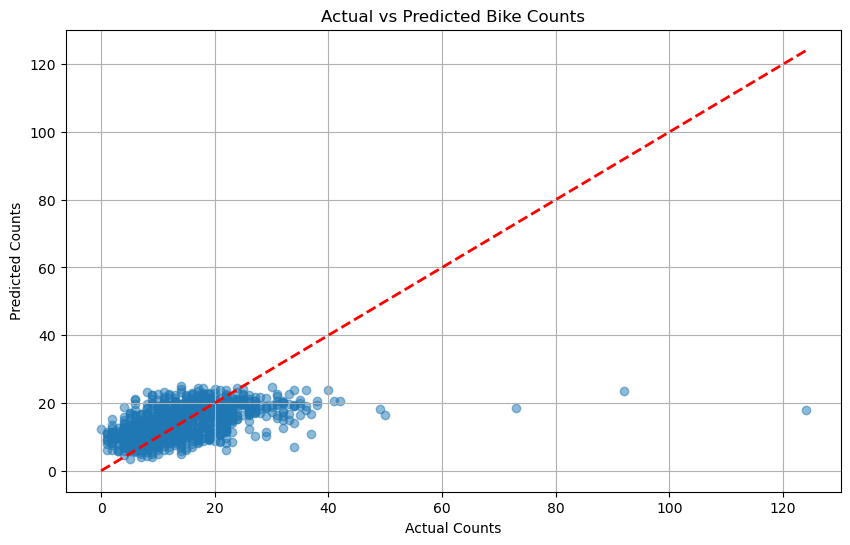

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Load datasets
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

# Check the lengths of datasets
print("Length of Fremont Bridge dataset:", len(counts))
print("Length of Bicycle Weather dataset:", len(weather))

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Merge on Date
data = counts.merge(weather, left_index=True, right_index=True, how='inner')

# Check the merged data
print("Merged Data Head:\n", data.head())
print("Columns in merged data:", data.columns.tolist())

# Adjust feature columns
feature_columns = ['PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']  # Choose relevant features

# Select X and y
X = data[feature_columns]
y = data['Fremont Bridge East Sidewalk'] + data['Fremont Bridge West Sidewalk']  # Adjust target as necessary

# Check for empty feature and target variables
if X.empty or y.empty:
    print("Feature or target variable is empty. Please check the column names and data types.")
else:
    # Define alpha range
    alpha_range = {'alpha': np.logspace(-4, 4, 50)}

    # Define each model
    lr_model = LinearRegression()
    lasso_model = Lasso()
    ridge_model = Ridge()

    # Cross-validation on LinearRegression
    lr_scores = cross_val_score(lr_model, X, y, cv=10, scoring=mse_scorer)

    # Tuning Lasso using RandomizedSearchCV
    lasso_search = RandomizedSearchCV(lasso_model, alpha_range, cv=10, scoring=mse_scorer, n_iter=20, random_state=42)
    lasso_search.fit(X, y)
    lasso_best_alpha = lasso_search.best_params_['alpha']
    lasso_best_score = lasso_search.best_score_

    # Tuning Ridge using RandomizedSearchCV
    ridge_search = RandomizedSearchCV(ridge_model, alpha_range, cv=10, scoring=mse_scorer, n_iter=20, random_state=42)
    ridge_search.fit(X, y)
    ridge_best_alpha = ridge_search.best_params_['alpha']
    ridge_best_score = ridge_search.best_score_

    # Model Scores
    print("Linear Regression CV Score:", np.mean(lr_scores))
    print("Lasso Regression CV Score:", lasso_best_score, "with alpha:", lasso_best_alpha)
    print("Ridge Regression CV Score:", ridge_best_score, "with alpha:", ridge_best_alpha)

# Fit the best model
lasso_best_model = Lasso(alpha=lasso_best_alpha)
lasso_best_model.fit(X, y)
y_pred = lasso_best_model.predict(X)

# Plotting Actual vs Predicted bike counts
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Bike Counts')
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.grid(True)
plt.show()
